In [1]:
import os
import sys
sys.path.append("lib")
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import utils
import classifier
from genre_data import genre_data

# Pre-training

## Set hyper parameters

NN_TYPE: type of neural network -> FNN, CNN, (bi)RNN, (bi)LSTM, (bi)GRU


PRECISON: precision of prediction -> 32/64


NUM_SEGMENTS: Number of segments per single track(music) -> 5,10


TEST_SIZE: Portion of test size in total dataset


VAL_SIZE: Portion of validation size in remaining dataset (1-TEST_SIZE)


DROPOUT: drop out rate of NN


OPTIMIZER_NAME: Name of optimizer to be used -> RMSprop, Adam, Adagrad, ...


LEARNING_RATE: learning rate of optimizer


L2_REGULARIZATION: L2 regularization factor for optimizer


LOSS_NAME: Name of loss function -> CrossEntropyLoss, MultiMarginLoss




In [19]:
#* Network type
NN_TYPE = 'biGRU'
PREFIX = NN_TYPE

#* Set default precision to double(float 64)
PRECISION = '32'
torch.set_default_dtype(getattr(torch, 'float' + PRECISION))
if PRECISION != '32':
    PREFIX += '_{}'.format(PRECISION)

#* Number of segments per single track
NUM_SEGMENTS = 10
if NUM_SEGMENTS != 10:
    PREFIX += '_NS{}'.format(NUM_SEGMENTS)

#* Data path
DATA_PATH = os.path.join("data", "genres_{}.json".format(NUM_SEGMENTS))

#* Portion of validation size
TEST_SIZE = 0.25
VAL_SIZE = 0.2

#* Drop out
DROPOUT = 0.4
if DROPOUT != 0.3:
    PREFIX += "_DO{:.2f}".format(DROPOUT)

#* Optimizer name
OPTIMIZER_NAME = 'RMSprop'
if OPTIMIZER_NAME != 'Adam':
    PREFIX += '_OP' + OPTIMIZER_NAME

#* Learning rate for optimizer
LEARNING_RATE = 5e-4
if LEARNING_RATE != 1e-4:
    PREFIX += "_LR{}".format(LEARNING_RATE)

#* Regularization for optimizer
L2_REGULARIZATION = 1e-2
if L2_REGULARIZATION != 1e-2:
    PREFIX += "_RG{}".format(L2_REGULARIZATION)

#* Loss function
LOSS_NAME = 'MultiMarginLoss'
if LOSS_NAME != 'CrossEntropyLoss':
    PREFIX += "_LF{}".format(LOSS_NAME)

#* Early stopping patience
PATIENCE = 10

print("prefix:", PREFIX)

#* Check device
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True   # For boost of CNN
    DEVICE = torch.device('cuda:0')
else:
    DEVICE = torch.device('cpu')
DEVICE


prefix: biGRU_DO0.40_OPRMSprop_LR0.0005_LFMultiMarginLoss


device(type='cuda', index=0)

## Generate dataset

In [3]:
data = genre_data(DATA_PATH,
                  nn_type=NN_TYPE,
                  val_size=VAL_SIZE,
                  precision=PRECISION,
                  verbose=True)
train_loader = data.get_train_loader(batch_size=64, num_workers=4)
val_loader = data.get_val_loader(batch_size=64, num_workers=4)


Finished reading a file data/genres_10.json
-----------------------------
Number of train set: 5997 with input: torch.Size([130, 13]) output: torch.Size([])
Number of validation set: 1500 with input: torch.Size([130, 13]) output: torch.Size([])
Number of test set: 2499 with input: torch.Size([130, 13]) output: torch.Size([])


## Define neural network, loss function, optimizer type

In [20]:
model = getattr(classifier, NN_TYPE)(input_shape=data.input.shape,
                                     output_size=data.output_size,
                                     dropout=DROPOUT).to(DEVICE)

#* Initialize epoch, loss, optimizer, loss function
epoch, min_val_loss = 0, np.Inf
train_loss_list, val_loss_list = np.array([]), np.array([])
train_accuracy_list, val_accuracy_list = np.array([]), np.array([])

optimizer = getattr(optim, OPTIMIZER_NAME)(params=model.parameters(),
                                           lr=LEARNING_RATE,
                                           weight_decay=L2_REGULARIZATION)
loss_func = getattr(nn, LOSS_NAME)(reduction='sum')

#* Summarize the model
example, _ = data.train_dataset[0]
utils.model_summary(model, input_size=example.shape, precision=PRECISION)


Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
├─GRU: 1-1                               [1, 130, 13]     [1, 130, 128]    --               104,832          13,428,480
|    └─weight_ih_l0                                                        [192, 13]
|    └─weight_hh_l0                                                        [192, 64]
|    └─weight_ih_l0_reverse                                                [192, 13]
|    └─weight_hh_l0_reverse                                                [192, 64]
|    └─weight_ih_l1                                                        [192, 128]
|    └─weight_hh_l1                                                        [192, 64]
|    └─weight_ih_l1_reverse                                                [192, 128]
|    └─weight_hh_l1_reverse                                                [192, 64]
├─Linear: 1-2                            [1, 128]         [1, 64]          [128

## Load model if needed

In [25]:
#* Load model
epoch = 48

checkpoint = torch.load(os.path.join('model', PREFIX + '_{}.pth'.format(epoch)),
                        map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']
train_loss_list = checkpoint['train_loss_list']
val_loss_list = checkpoint['val_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
val_accuracy_list = checkpoint['val_accuracy_list']
min_val_loss = val_loss_list[-1]
test_loss = checkpoint['test_loss']
test_accuracy = checkpoint['test_accuracy']

try:
    print("REMARK:", checkpoint['Remark'])
except KeyError:
    pass

print("Loaded model has test loss: {:.6f}".format(test_loss))
for genre, accuracy in test_accuracy.items():
    print("{}: {:.1f}%".format(genre, accuracy))

REMARK: Early stopped
Loaded model has test loss: 0.112017
hiphop: 70.9%
classical: 90.2%
blues: 89.1%
metal: 91.6%
jazz: 81.9%
country: 76.6%
pop: 83.9%
rock: 55.8%
disco: 59.5%
reggae: 83.8%
tot: 78.1%


# Training

In [26]:
loss_history, accuracy_history, best = utils.train(model,
                                                   max_epoch=100,
                                                   loss_func=loss_func,
                                                   optimizer=optimizer,
                                                   train_loader=train_loader,
                                                   val_loader=val_loader,
                                                   early_stop_counter=PATIENCE,
                                                   min_val_loss=min_val_loss,
                                                   verbose=1)
new_train_loss_list, new_val_loss_list = loss_history
new_train_accuracy_list, new_val_accuracy_list = accuracy_history

#* Load best model state and epoch number
best_epoch = best[1]
if best[0] is None:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(best[0])

#* Update epoch and loss lists, accuracy lists
epoch += best_epoch + 1
train_loss_list = np.concatenate((train_loss_list,
                                  new_train_loss_list[:best_epoch + 1 + PATIENCE]))
val_loss_list = np.concatenate((val_loss_list,
                                new_val_loss_list[:best_epoch + 1 + PATIENCE]))
train_accuracy_list = np.concatenate((train_accuracy_list,
                                      new_train_accuracy_list[:best_epoch + 1 + PATIENCE]))
val_accuracy_list = np.concatenate((val_accuracy_list,
                                    new_val_accuracy_list[:best_epoch + 1 + PATIENCE]))


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1	Early Stopping counter: 1/10
Epoch 2	Early Stopping counter: 2/10
Epoch 3	Early Stopping counter: 3/10
Epoch 4	Early Stopping counter: 4/10
Epoch 5	Early Stopping counter: 5/10
Epoch 6	Early Stopping counter: 6/10
Epoch 7	Early Stopping counter: 7/10
Epoch 8	Early Stopping counter: 8/10
Epoch 9	Early Stopping counter: 9/10
Epoch 10	Early Stopping counter: 10/10
Early Stopping!
Train finished with 39.602136 seconds


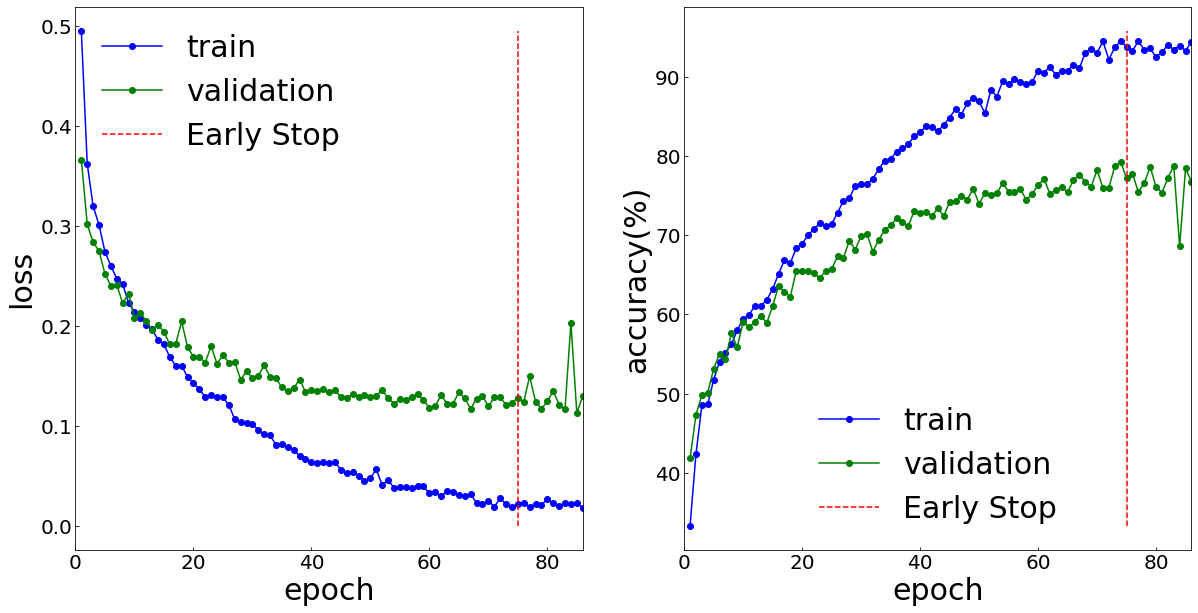

In [14]:
ax1, ax2 = utils.plot_loss_accuracy(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, epoch)
_ = ax1.set_xlim([0, epoch+PATIENCE+1])
_ = ax2.set_xlim([0, epoch+PATIENCE+1])


# Test

Test loss: 0.125231	Test accuracy: 76.31%
Test finished with 12.36 seconds


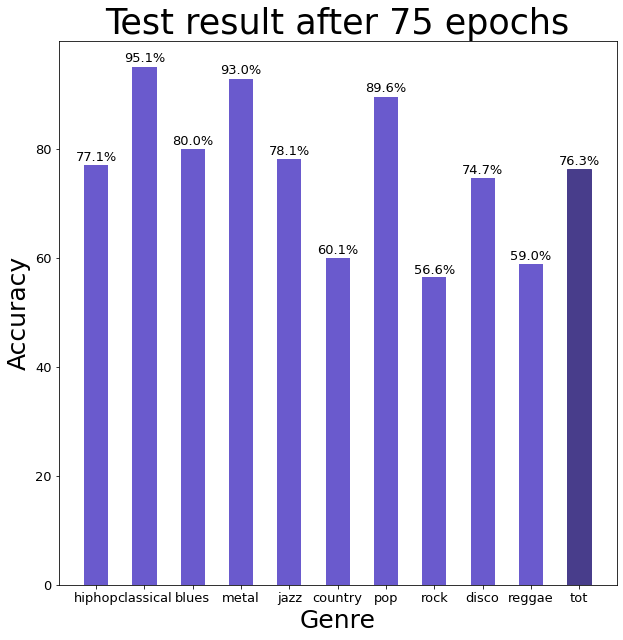

In [15]:
accuracy, (test_loss, test_accuracy) = utils.test(model, data,
                                                  loss_func=loss_func,
                                                  verbose=True)
ax = utils.plot_accuracy(accuracy, epoch)


# Save the model

In [16]:
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'train_loss_list': train_loss_list[:epoch],
            'val_loss_list': val_loss_list[:epoch],
            'train_accuracy_list': train_accuracy_list[:epoch],
            'val_accuracy_list': val_accuracy_list[:epoch],
            'Remark': 'Early stopped',
            'test_loss': test_loss,
            'test_accuracy': test_accuracy
            },
           os.path.join('model', PREFIX + '_{}.pth'.format(epoch)))
print("Saved model", PREFIX + '_{}.pth'.format(epoch))


Saved model biLSTM_DO0.40_OPRMSprop_LR0.0005_LFMultiMarginLoss_75.pth


# Find best model

In [24]:
best_accuracy = 0
for file in os.listdir('model'):
    checkpoint = torch.load(os.path.join('model', file))
    try:
        if checkpoint['test_accuracy']['tot'] > best_accuracy:
            best_name = file
            best_accuracy = checkpoint['test_accuracy']['tot']
    except KeyError:
        print("Error: ", file)
print(best_name, best_accuracy)

biGRU_DO0.40_OPRMSprop_LR0.0005_LFMultiMarginLoss_48.pth 78.07122849139657
